## Imports

In [67]:
!wget https://lodmedia.hb.bizmrg.com/case_files/993641/train_dataset_%D0%A1%D0%B8%D0%BD%D1%82%D0%B5%D0%B7.zip

^C


In [68]:
!unzip -q /content/train_dataset_Синтез.zip

replace golfclub_bboxes.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
!pip install mediapipe-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import shutil
import gc

from tqdm.notebook import tqdm
from mediapipe_model_maker import image_classifier
from mediapipe_model_maker import object_detector
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
!pip install mediapipe

In [4]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

## Create pose dataset

In [5]:
class Video():
    def __init__(self, filename):
        cap = cv2.VideoCapture(filename)
        self.filename = filename
        self.readed = False
        self.length = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        self.fps = cap.get(cv2.CAP_PROP_FPS)
        self.time = self.length/self.fps
        self.width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        self.height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

        if not cap.isOpened():
            print("The file doesn't exist, or it's not a video")
            raise FileExistsError
        else:
            self.cap = cap


    def read_frame(self, n=-1, return_mode='RGB'):
        current_frame = self.current_frame_number()
        if n != -1:
            self.set_frame(n)

        cap = self.cap
        self.readed = True

        if cap.isOpened():
            ret, frame = cap.read()
            if frame is None:
                return None
            if return_mode == 'RGB':
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if n != -1:
                self.set_frame(current_frame + 1)
            return frame
        return None


    def set_frame(self, n):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, n)


    def current_frame_number(self):
        return self.cap.get(cv2.CAP_PROP_POS_FRAMES)


    def return_list(self, n=-1, return_mode='RGB'):
        current_frame = self.current_frame_number()
        startframe = 0

        if n != -1:
            startframe = n

        self.set_frame(startframe)
        frames = []
        frame = self.read_frame()

        # while frame[0] is not None:
        while frame is not None:
            if self.current_frame_number() == self.length:
                break
            frames.append(frame)
            frame = self.read_frame(return_mode=return_mode)
        print('Done')

        self.set_frame(current_frame)

        return frames

In [7]:
pose_data = pd.read_excel('/content/positions_markup_train.xlsx')
pose_data

,Название видео,P1,P2,P3,P4,P5,P7,P8,P10
0,ab714ca7-1515-41b8-af25-70af3b04a871.mp4,4,22,23,33,42,45,46,56
1,4ea3cf67-92b9-465b-a11f-1baf8005d3c4.mp4,286,391,431,504,568,600,614,691
2,fca75c7c-0845-404c-8574-839885cb5a94.mp4,290,334,341,382,411,420,432,463
3,ea7bb598-3f31-49b3-a76b-f0edf0cc6aeb.mp4,0,14,15,26,36,41,44,56
4,62789a67-124c-47e1-92b9-77829341959f.mp4,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...
81,8f3d1f47-ad3a-4354-b26d-fba679f26032.mp4,50,64,68,76,83,88,90,101
82,27b7af84-2899-400e-acee-17833c3a122f.mp4,-,-,-,-,-,-,-,-
83,53328ebb-8501-4a56-ae2e-870a2aeac387.mp4,55,65,67,75,83,89,92,107
84,d4d18945-10e8-41cd-98c1-0777f27b621e.mp4,42,162,184,227,263,302,321,403


In [4]:
%mkdir pose_data
%cd pose_data

/content/pose_data


In [5]:
poses = pose_data.columns[1:]
for pose in poses:
    os.mkdir(pose)

%cd /content

/content


In [10]:
for i in tqdm(range(0, pose_data.shape[0])):
    row = pose_data.iloc[i]
    if '-' in row.values:
        continue
    video = Video('/content/positions_of_the_golf_swing_train/' + row[0])
    # print(video.length, video.fps)
    for pose in poses:
        frame = video.read_frame(row[pose])
        cv2.imwrite(f'/content/pose_data/{pose}/{row[0][:-4]}_{row[pose]}.jpg', frame)

  0%|          | 0/84 [00:00<?, ?it/s]

In [12]:
shutil.make_archive('pose_data', 'zip', '/content/pose_data')

'/content/pose_data.zip'

In [13]:
shutil.copy('/content/pose_data.zip', '/content/drive/MyDrive/Olymps/leadersofdigital/spb')

'/content/drive/MyDrive/Olymps/leadersofdigital/spb/pose_data.zip'

## Pose EfficientNet-Lite0 training

Data structure:
```
flower_photos
|__ daisy
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ dandelion
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...
```

In [ ]:
# image_path = tf.keras.utils.get_file(
#     'flower_photos.tgz',
#     'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#     extract=True)
# image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

228813984/228813984 [==============================] - 2s 0us/step


In [14]:
%cd /content/drive/MyDrive/Olymps/leadersofdigital/spb

/content/drive/MyDrive/Olymps/leadersofdigital/spb


In [19]:
%mkdir pose_data
%cd pose_data
!unzip -q ../pose_data.zip
%cd ..

mkdir: cannot create directory ‘pose_data’: File exists
/content/drive/MyDrive/Olymps/leadersofdigital/spb/pose_data
/content/drive/MyDrive/Olymps/leadersofdigital/spb


In [20]:
image_path = '/content/drive/MyDrive/Olymps/leadersofdigital/spb/pose_data'

In [21]:
data = image_classifier.Dataset.from_folder(image_path)
train_data, val_data = data.split(0.9)

In [25]:
spec = image_classifier.SupportedModels.EFFICIENTNET_LITE0
hparams = image_classifier.HParams(export_dir="exported_model")
options = image_classifier.ImageClassifierOptions(supported_model=spec, hparams=hparams)

In [31]:
model = image_classifier.ImageClassifier.create(
    train_data=train_data,
    validation_data=val_data,
    options=options,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              3413024   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 10248     
                                                                 
Total params: 3423272 (13.06 MB)
Trainable params: 10248 (40.03 KB)
Non-trainable params: 3413024 (13.02 MB)
_________________________________________________________________
None
Resuming from exported_model/checkpoint/model-0010
Epoch 1/10
262/262 [==============================] - 53s 192ms/step - loss: 1.9079 - accuracy: 0.3073 - val_loss: 1.6862 - val_accuracy: 0.5085
Epoch 2/10
262/262 [==============================] - 46s 175ms/step - los

In [ ]:
loss, acc = model.evaluate(val_data)
print(f'Test loss:{loss}, Test accuracy:{acc}')

In [32]:
model.export_model('golf_efflite_3_0.5424.tflite')

## Pose algorithm

Алгоритм определения позы
1. ждем пока вероятность Р1 станет больше остальных, отмечаем этот кадр как Р1, исключаем Р1 из возможных классов
2. ждем Р2, отмечаем Р2, исключ Р2 из возможных
...

In [6]:
def pred_frame_pose(classifier, numpy_image):
    # Load the input image from a numpy array.
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_image)
    # Perform image classification on the provided single image.
    classification_result = classifier.classify(mp_image)
    return classification_result.classifications[0].categories[0].category_name


def get_frames(video_path):
    video = Video(video_path)
    return video.return_list()

In [7]:
# def pose_order_algo(model, video_path):
#     frames = get_frames(video_path)
#     phases = ['P1', 'P2', 'P3', 'P4', 'P5', 'P7', 'P8', 'P10']
#     ids = []
#     for i in range(0, len(frames), 2):
#         # model returns 'P<num>'
#         # print('pred:', pred_frame_pose(model, frames[i]))
#         # print(phases[len(ids)])
#         if pred_frame_pose(model, frames[i]) == phases[len(ids)]:
#             ids.append(i)
#             print(ids)
#     if len(ids) > len(phases):
#         print('ERROR', ids)
#     if len(ids) < len(phases):
#         ids += [len(frames)] * (len(phases) - len(ids))
#     return ids

In [7]:
def pose_mean_algo(model, video_path):
    frames = get_frames(video_path)
    phases = ['P1', 'P2', 'P3', 'P4', 'P5', 'P7', 'P8', 'P10']
    phd = dict([(ph, []) for ph in phases])
    # ids = []
    for i in range(0, len(frames), 2):
        # model returns 'P<num>'
        pred = pred_frame_pose(model, frames[i])
        phd[pred] += [i]
    ids = []
    for i, pn in enumerate(list(phd.values())):
        if len(pn) == 0:
            if i == 0:
                ids.append(0)
            else:
                ids.append(ids[i - 1] + 2)
        else:
            if len(ids) == 0:
                ids.append(sum(pn) // len(pn) + 1)
            else:
                if ids[i - 1] < sum(pn) // len(pn) + 1:
                    ids.append(sum(pn) // len(pn) + 1)
                else:
                    ids.append(ids[i - 1] + 2)
    gc.collect()
    # if len(ids) > len(phases):
    #     print('ERROR', ids)
    # if len(ids) < len(phases):
    #     ids += [len(frames)] * (len(phases) - len(ids))
    return ids, frames

## Compute accuracy

In [8]:
def get_pose_clf(pose_model_path):
    base_options = python.BaseOptions(model_asset_path=pose_model_path)
    options = vision.ImageClassifierOptions(
        base_options=base_options, max_results=4)
    pose_clf = vision.ImageClassifier.create_from_options(options)
    return pose_clf

In [9]:
# pose_model_path = '/content/drive/MyDrive/Olymps/leadersofdigital/spb/exported_model/golf_efflite_3_0.5424.tflite'
pose_model_path = '/content/drive/MyDrive/Olymps/leadersofdigital/spb/pose_exported_model/golf_efflite_2_0.5085.tflite'
pose_clf = get_pose_clf(pose_model_path)

In [26]:
pose_data = pd.read_excel('/content/positions_markup_train.xlsx')
pose_data = pose_data[pose_data['P1'] != '-'].reset_index(drop=True)
pose_data

,Название видео,P1,P2,P3,P4,P5,P7,P8,P10
0,ab714ca7-1515-41b8-af25-70af3b04a871.mp4,4,22,23,33,42,45,46,56
1,4ea3cf67-92b9-465b-a11f-1baf8005d3c4.mp4,286,391,431,504,568,600,614,691
2,fca75c7c-0845-404c-8574-839885cb5a94.mp4,290,334,341,382,411,420,432,463
3,ea7bb598-3f31-49b3-a76b-f0edf0cc6aeb.mp4,0,14,15,26,36,41,44,56
4,37356e9e-fc6b-40fa-a7f1-398018feee70.mp4,16,29,32,42,50,53,54,64
...,...,...,...,...,...,...,...,...,...
68,e12aa2a9-7d36-4ae4-9364-e6229836d5e9.mp4,10,24,27,39,49,52,54,67
69,e233254f-f54c-4103-9a9f-8b2bf7295e63.mp4,0,10,12,24,33,37,39,54
70,8f3d1f47-ad3a-4354-b26d-fba679f26032.mp4,50,64,68,76,83,88,90,101
71,53328ebb-8501-4a56-ae2e-870a2aeac387.mp4,55,65,67,75,83,89,92,107


In [27]:
def acc_pose(model, df):
    corr, total = 0, df.shape[0] * (df.shape[1] - 1)
    for i in tqdm(range(df.shape[0])):
        row = pose_data.iloc[i]
        y_true = row[1:].tolist()
        y_pred = pose_mean_algo(model, '/content/positions_of_the_golf_swing_train/' + row[0])
        corr += sum([abs(t - p) <= 60 for t, p in zip(y_true, y_pred)])
    return corr / total

In [ ]:
acc_pose(pose_clf, pose_data)

In [ ]:
sample = pd.read_csv('/content/submission.csv', sep=';')
sample

In [10]:
def make_submission(model, submit_path, video_path):
    sample = pd.read_csv(submit_path, sep=';')
    for i in sample.index.tolist():
        row = sample.iloc[i]
        pred = pose_mean_algo(model, video_path + row[0])
        sample.iloc[i, 1:] = pred
    sample.to_csv('fmprojects.csv')
    return sample

In [ ]:
make_submission(pose_clf, '/content/submission.csv', '/content/positions_of_the_golf_swing_train/')

## Train MobileNet v2 (unused)

In [51]:
%cd /content/drive/MyDrive/Olymps/leadersofdigital/spb/balls_data

/content/drive/MyDrive/Olymps/leadersofdigital/spb/balls_data


In [44]:
!unzip /content/drive/MyDrive/Olymps/leadersofdigital/spb/balls_new.zip

Archive:  /content/drive/MyDrive/Olymps/leadersofdigital/spb/balls_new.zip
   creating: train/
  inflating: __MACOSX/._train        
  inflating: train/labels.json       
  inflating: __MACOSX/train/._labels.json  
  inflating: train/.DS_Store         
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/images/
  inflating: train/images/c492f23e-c9e6-4d89-8148-62ae3ba73894_frame_82_jpg.rf.99584487e663f5781581fa657e5bfee5.jpg  
  inflating: __MACOSX/train/images/._c492f23e-c9e6-4d89-8148-62ae3ba73894_frame_82_jpg.rf.99584487e663f5781581fa657e5bfee5.jpg  
  inflating: train/images/e04e2f94-14c3-4502-aeae-228bce064b8c_frame_33_jpg.rf.a558e2175b2c504ad1684aabf3cab96e.jpg  
  inflating: __MACOSX/train/images/._e04e2f94-14c3-4502-aeae-228bce064b8c_frame_33_jpg.rf.a558e2175b2c504ad1684aabf3cab96e.jpg  
  inflating: train/images/c23219c1-c3f9-421b-82c9-fbddea482354_frame_82_jpg.rf.ac0273fb297cdd39968b3a6b66688f2b.jpg  
  inflating: __MACOSX/train/images/._c23219c1-c3f9-421b-82c9-fbdde

### Ball detection

In [46]:
train_data = object_detector.Dataset.from_coco_folder('/content/drive/MyDrive/Olymps/leadersofdigital/spb/balls_data/train')#, cache_dir="/tmp/od_data/train")
validation_data = object_detector.Dataset.from_coco_folder('/content/drive/MyDrive/Olymps/leadersofdigital/spb/balls_data/valid')#, cache_dir="/tmp/od_data/validation")
print("train_data size: ", train_data.size)
print("validation_data size: ", validation_data.size)

train_data size:  76
validation_data size:  14


In [47]:
%cd /content

/content


In [53]:
spec = object_detector.SupportedModels.MOBILENET_MULTI_AVG
hparams = object_detector.HParams(export_dir='exported_model')
options = object_detector.ObjectDetectorOptions(
    supported_model=spec,
    hparams=hparams
)

In [54]:
model = object_detector.ObjectDetector.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Model: "retina_net_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobile_net_1 (MobileNet)    {'2': (None, 64, 64, 32   3704416   
                             ),                                  
                              '3': (None, 32, 32, 64             
                             ),                                  
                              '4': (None, 16, 16, 16             
                             0),                                 
                              '5': (None, 8, 8, 192)             
                             , '6': (None, 1, 1, 128             
                             0)}                                 
                                                                 
 fpn_1 (FPN)                 {'5': (None, 8, 8, 128)   144928    
                             , '4': (None, 16, 16, 1             
                             28),               

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


9/9 [==============================] - 57s 2s/step - total_loss: 67.7260 - cls_loss: 65.1109 - box_loss: 0.0510 - model_loss: 67.6631 - val_total_loss: 3.2890 - val_cls_loss: 1.4663 - val_box_loss: 0.0352 - val_model_loss: 3.2261
Epoch 2/30
9/9 [==============================] - 15s 2s/step - total_loss: 2.2105 - cls_loss: 1.0358 - box_loss: 0.0222 - model_loss: 2.1475 - val_total_loss: 2.1907 - val_cls_loss: 0.7850 - val_box_loss: 0.0269 - val_model_loss: 2.1277
Epoch 3/30
9/9 [==============================] - 16s 2s/step - total_loss: 1.5811 - cls_loss: 0.7847 - box_loss: 0.0147 - model_loss: 1.5181 - val_total_loss: 1.4162 - val_cls_loss: 0.5826 - val_box_loss: 0.0154 - val_model_loss: 1.3531
Epoch 4/30
9/9 [==============================] - 16s 2s/step - total_loss: 1.2468 - cls_loss: 0.5514 - box_loss: 0.0126 - model_loss: 1.1837 - val_total_loss: 1.7997 - val_cls_loss: 0.5656 - val_box_loss: 0.0234 - val_model_loss: 1.7365
Epoch 5/30
9/9 [==============================] - 16s 2s

In [55]:
model.export_model('mobilenet_avg_ball_1.tflite')

Exporting a floating point model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


## Pose estimation

In [66]:
def get_landmarker(model_path):
    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode
    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE
    )
    return PoseLandmarker.create_from_options(options)


def find_landmarks(landmarker, numpy_image):
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_image)
    pose_landmarker_result = landmarker.detect(mp_image)
    return pose_landmarker_result

In [30]:
landmarker = get_landmarker('/content/drive/MyDrive/Olymps/leadersofdigital/spb/keypoints/pose_landmarker_lite.task')
landmarker

In [41]:
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_utils.DrawingSpec(color=(245,117,66), thickness=5, circle_radius=7),
            mp.solutions.drawing_utils.DrawingSpec(color=(245,66,230), thickness=5, circle_radius=7))
    return annotated_image

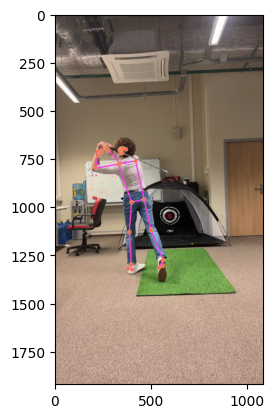

In [42]:
image = cv2.imread("/content/bboxes/00858b25-c5c3-4092-8ae7-5c61ada25097_frame_77.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points = find_landmarks(landmarker, image)
plt.imshow(draw_landmarks_on_image(image, points))
plt.show()

In [ ]:
NOSE = 0
LEFT_EYE_INNER = 1
LEFT_EYE = 2
LEFT_EYE_OUTER = 3
RIGHT_EYE_INNER = 4
RIGHT_EYE = 5
RIGHT_EYE_OUTER = 6
LEFT_EAR = 7
RIGHT_EAR = 8
MOUTH_LEFT = 9
MOUTH_RIGHT = 10
LEFT_SHOULDER = 11
RIGHT_SHOULDER = 12
LEFT_ELBOW = 13
RIGHT_ELBOW = 14
LEFT_WRIST = 15
RIGHT_WRIST = 16
LEFT_PINKY = 17
RIGHT_PINKY = 18
LEFT_INDEX = 19
RIGHT_INDEX = 20
LEFT_THUMB = 21
RIGHT_THUMB = 22
LEFT_HIP = 23
RIGHT_HIP = 24
LEFT_KNEE = 25
RIGHT_KNEE = 26
LEFT_ANKLE = 27
RIGHT_ANKLE = 28
LEFT_HEEL = 29
RIGHT_HEEL = 30
LEFT_FOOT_INDEX = 31
RIGHT_FOOT_INDEX = 32

In [99]:
def head_movement(points1, points2, thresh=50):
    x1, y1 = points1.pose_landmarks[0][1].x, points1.pose_landmarks[0][1].y
    x2, y2 = points2.pose_landmarks[0][1].x, points2.pose_landmarks[0][1].y
    dist = (((x1 - x2) * 1920) ** 2 + ((y1 - y2) * 1080) ** 2) ** 0.5
    return dist

In [100]:
points.pose_landmarks[0][1].x

0.31533464789390564

In [59]:
mp.solutions.pose.PoseLandmark[0]

KeyError: ignored

In [ ]:
draw_landmarks_on_image

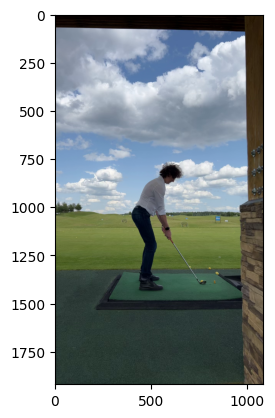

In [106]:
%matplotlib inline
video = Video('/content/raw/Righty/08015f3d-bc0d-4821-bba9-721876ceefec.mp4')
# find_landmarks(landmarker, )
plt.imshow(video.read_frame(0))
plt.show()

In [ ]:
pose_model_path = '/content/drive/MyDrive/Olymps/leadersofdigital/spb/pose_exported_model/golf_efflite_2_0.5085.tflite'
pose_clf = get_pose_clf(pose_model_path)

In [76]:
len(frames)

87

In [1]:
pose_clf = get_pose_clf('/content/drive/MyDrive/Olymps/leadersofdigital/spb/pose_exported_model/golf_efflite_2_0.5085.tflite')
y_pred, frames = pose_mean_algo(pose_clf, '/content/raw/Righty/08015f3d-bc0d-4821-bba9-721876ceefec.mp4')
print('Predicted phase changes:', y_pred)

landmarker = get_landmarker('/content/drive/MyDrive/Olymps/leadersofdigital/spb/keypoints/pose_landmarker_lite.task')
points1 = find_landmarks(landmarker, frames[y_pred[0]])
try:
    points2 = find_landmarks(landmarker, frames[y_pred[3]])
except:
    points2 = find_landmarks(landmarker, frames[-1])
try:
    dist = head_movement(points1, points2)
    if dist > 50:
        print(f'Found mistake: head movement by {dist:.2f} pixels')
    else:
        print(f'Head movement not detected, {dist:.2f} pixels')
except:
    points1 = find_landmarks(landmarker, frames[0])
    points2 = find_landmarks(landmarker, frames[len(frames) // 4])
    try:
        dist = head_movement(points1, points2)
        if dist > 50:
            print(f'Found mistake: head movement by {dist:.2f} pixels')
        else:
            print(f'Head movement not detected, {dist:.2f} pixels')
    except:
        print('Error detecting person')


NameError: ignored

In [111]:
len(frames)

187

In [110]:
points1

PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)

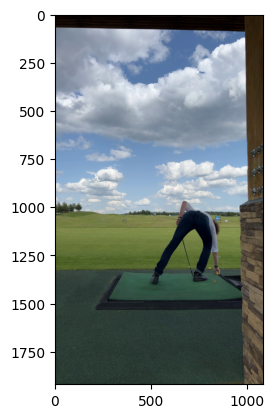

In [112]:
points = find_landmarks(landmarker, frames[170])
plt.imshow(draw_landmarks_on_image(frames[170], points))
plt.show()

In [104]:
def angle(points1, thresh=35):
    x1, y1 = points1.pose_landmarks[0][23].x, points1.pose_landmarks[0][23].y
    x2, y2 = points1.pose_landmarks[0][24].x, points1.pose_landmarks[0][24].y
    dist = (((x1 - x2) * 1920) ** 2 + ((y1 - y2) * 1080) ** 2) ** 0.5
    if dist > thresh:
        return 'Face On'
    return 'Down the Line'

53.052229774822784

In [29]:
# utils for drawing on image
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# mediapipe pose model
mp_pose = mp.solutions.pose.Pose(
        static_image_mode=False,
        model_complexity=2,
        enable_segmentation=False,
        min_detection_confidence=0.5)

image = cv2.imread("/content/bboxes/00858b25-c5c3-4092-8ae7-5c61ada25097_frame_77.jpg")
#convert image to RGB (just for input to model)
image_input = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get results using mediapipe
results = mp_pose.process(image_input)

if not results.pose_landmarks:
    print("no results found")
else:
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

# write image to storage
# cv2.imwrite("./ronaldo-processed.jpg", image)

AttributeError: ignored

In [ ]:
plt.imshow(image)
plt.show()

## Unused

In [ ]:
images = []
predictions = []
for image_name in IMAGE_FILENAMES:
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_name)

  # STEP 4: Classify the input image.
  classification_result = classifier.classify(image)

  # STEP 5: Process the classification result. In this case, visualize it.
  images.append(image)
  top_category = classification_result.classifications[0].categories[0]
  predictions.append(f"{top_category.category_name} ({top_category.score:.2f})")

display_batch_of_images(images, predictions)

In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/993641/train_dataset_%D0%A1%D0%B8%D0%BD%D1%82%D0%B5%D0%B7.zip

--2023-08-25 16:01:42--  https://lodmedia.hb.bizmrg.com/case_files/993641/train_dataset_%D0%A1%D0%B8%D0%BD%D1%82%D0%B5%D0%B7.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 95.163.53.117
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328990306 (11G) [application/zip]
Saving to: ‘train_dataset_Синтез.zip’

train_dataset_Синте 100%[===================>]  10.55G  23.1MB/s    in 8m 2s   

2023-08-25 16:09:46 (22.4 MB/s) - ‘train_dataset_Синтез.zip’ saved [11328990306/11328990306]



In [ ]:
!unzip -q /content/train_dataset.zip

In [36]:
!gdown 1uBwRxFxW04EqG87VCoX3l6vXeV5T5JYJ

Downloading...
From: https://drive.google.com/uc?id=1uBwRxFxW04EqG87VCoX3l6vXeV5T5JYJ
To: /content/videos_160.zip
100% 699M/699M [00:07<00:00, 99.2MB/s]


In [37]:
%cd videos_160
!unzip -q /content/videos_160.zip

/content/videos_160


In [ ]:
!ls /content/videos_160/videos_160